## Libraries

In [9]:
# !pip freeze > requirements.txt

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys

sys.path.append(os.path.abspath("SuperPoint\dataset\CGTD_Tool"))
sys.path.append(os.path.abspath("SuperPoint\dataset\CGTD_Tool\SuperPoint-master"))


from utils import plot_imgs
from GroundTruthGenerator import GroundTruthGenerator


None
True
device: cpu


## Plotting

plot maps:

In [2]:
def plot_pairs(names):
    images = []
    # خواندن و نرمال‌سازی تصاویر
    for name in names:
        # path = os.path.join(base_url, name)
        img = cv2.imread(name).mean(-1) / 255.
        images.append(img)

    h, w = np.array([i.shape for i in images]).min(0)
    images = np.stack([i[:h, :w] for i in images])

    # رسم تصاویر
    plot_imgs(images, cmap='gray')

    return images

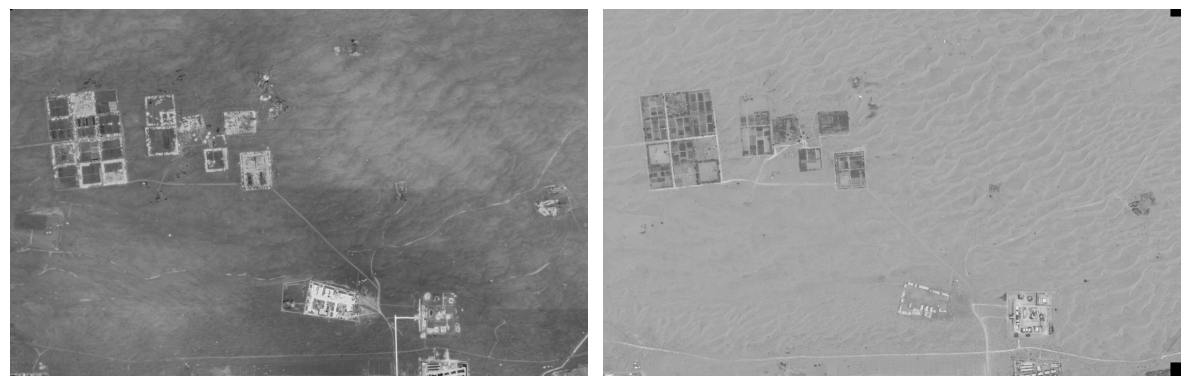

In [3]:
names = [r"IDM\thermal_reconstructed_map.png", r"IDM\satellite_reconstructed_map.png"]
images  = plot_pairs(names)


plot tiles:

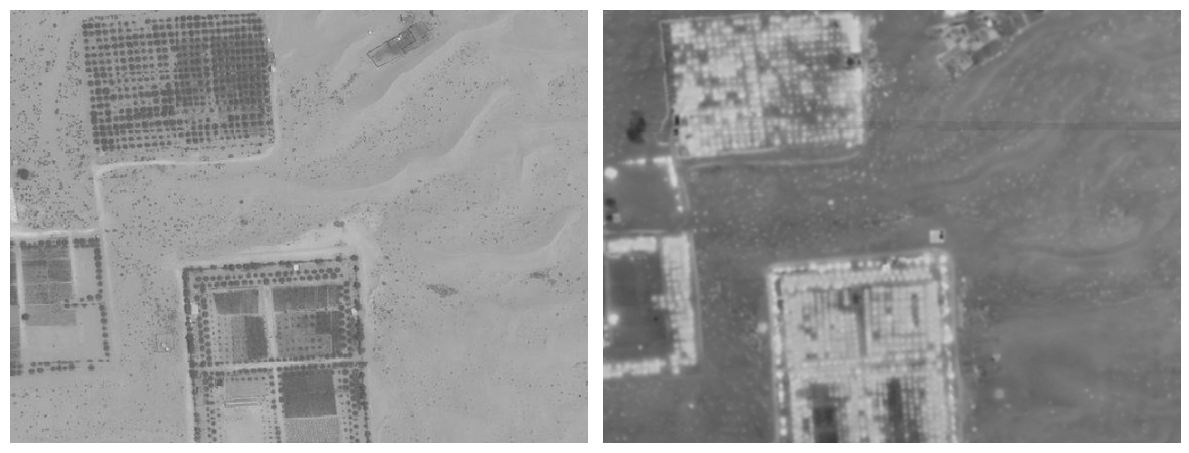

In [4]:
tiles_names = [r"dataset\CGTD_Tool\dataset\rgb\satellite_tile_1.png", r"dataset\CGTD_Tool\dataset\thermal\thermal_tile_1.png"]
tiles = plot_pairs(tiles_names)

In [5]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def plot_tile_on_map_image(json_files, tile_index, map_image_path, pad=10):
    """
    رسم یک tile مشخص از هر فایل JSON روی تصویر نقشه با رنگ متفاوت.
    با اضافه کردن padding برای جلوگیری از همپوشانی.
    """
    if not json_files:
        raise ValueError("json_files list is empty.")

    # بارگذاری تصویر نقشه
    map_img = cv2.imread(map_image_path)
    map_img = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(map_img)
    ax.set_aspect('equal')
    ax.axis('off')

    colors = ['blue', 'green']  # رنگ‌ها برای هر tile، می‌تونی بیشتر هم اضافه کنی

    for idx, jf in enumerate(json_files):
        with open(jf, 'r') as f:
            data = json.load(f)

        tile_names = list(data.keys())
        if tile_index < 0 or tile_index >= len(tile_names):
            raise ValueError("tile_index out of range for tiles in JSON file.")

        tile_name = tile_names[tile_index]
        corners = data[tile_name]

        # اضافه کردن padding به هر مختصات
        polygon_points = [
            [corners["top_left"][0] + idx * pad, corners["top_left"][1] + idx * pad],
            [corners["top_right"][0] + idx * pad, corners["top_right"][1] + idx * pad],
            [corners["bottom_right"][0] + idx * pad, corners["bottom_right"][1] + idx * pad],
            [corners["bottom_left"][0] + idx * pad, corners["bottom_left"][1] + idx * pad],
        ]

        polygon = patches.Polygon(
            polygon_points, closed=True, fill=False, 
            edgecolor=colors[idx % len(colors)], linewidth=2
        )
        ax.add_patch(polygon)

    plt.title(f"Tile layout for tile index {tile_index}")
    plt.show()


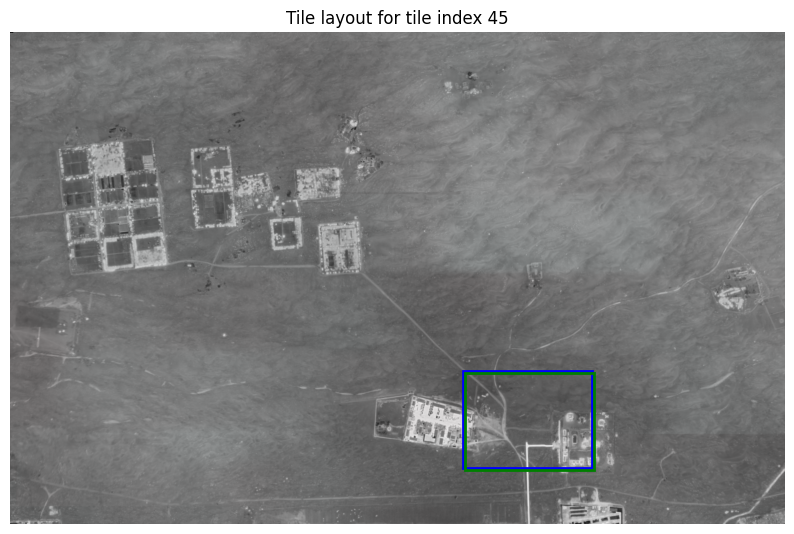

In [6]:
json_files = [r"dataset\CGTD_Tool\dataset\satellite_tile_coords.json", r"dataset\CGTD_Tool\dataset\satellite_tile_coords.json"]
map_image_path = names[0]
plot_tile_on_map_image(json_files, tile_index=45, map_image_path=map_image_path)


## model

In [2]:
# مسیرها
data_dir = r"dataset\CGTD_Tool\dataset"
backend_dir = r"dataset\CGTD_Tool\output"
sp_model_path = r"dataset\CGTD_Tool\SuperGluePretrainedNetwork-master\models\weights\superpoint_v1_ml.pth"

### Finding best Superpoint params:

In [3]:
import sys
output_dir = r"dataset\CGTD_Tool\dataset"
test_dir = r"dataset\CGTD_Tool\test_dataset"

sys.argv = [
    "dummy_name.py",                 
    "--dataset_dir", test_dir,     # مسیر دیتاست
    "--output_dir", output_dir ,   # مسیر ذخیره نتایج
    "--backend_dir", backend_dir,    # مسیر بک‌اند
    "--sp_model_path", sp_model_path,  # مسیر وزن‌های SuperPoint
    "--alpha", "0.5"                # وزن alpha
]

from main import main 
main()


Loaded SuperPoint model
[DEBUG] SuperPoint weights loaded from F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperPoint-master\weights\superpoint_v1_ml.pth
Loaded SuperGlue model ("outdoor" weights)
[GroundTruthGenerator] Models loaded on cpu
[DEBUG] GroundTruthFileWriter initialized with backend directory: F:\IDM\SuperPoint\dataset\CGTD_Tool\output
tensor(0.0944) tensor(0.0663)
tensor(0.1065) tensor(0.0904)
tensor(0.0982) tensor(0.0912)
tensor(0.1040) tensor(0.0912)
tensor(0.0903) tensor(0.0760)
tensor(0.1045) tensor(0.0867)
tensor(0.0848) tensor(0.0684)
tensor(0.0923) tensor(0.0639)
tensor(0.0744) tensor(0.0508)
tensor(0.0951) tensor(0.0584)
tensor(0.1209) tensor(0.1122)
tensor(0.1152) tensor(0.0961)
tensor(0.0967) tensor(0.0816)
[DEBUG]: matches -> [0, 31, 3, 0, 54, 0, 2, 6, 0, 5, 129, 211, 28]
[INFO] Config tested. Mean=36.08, Std=61.38, Score=5.39
Loaded SuperPoint model
[DEBUG] SuperPoint weights loaded from F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperPoint-master\weights\superpoint_v1_ml.pth

### test

In [3]:
custom_sp_config = {
    'nms_radius': 3,
    'keypoint_threshold': 0.005,
    'max_keypoints': 1500,
}

custom_sg_config = {
    'weights': 'outdoor',
    'sinkhorn_iterations': 20,
    'match_threshold': 0.1
}

gt_gen = GroundTruthGenerator(
    data_dir=data_dir,
    backend_dir=backend_dir,
    pair_ids=["tile_3", "tile_11"],
    debug=True,
    sp_model_path=sp_model_path,
    sp_config=custom_sp_config,
    sg_config=custom_sg_config
)



Loaded SuperPoint model
[DEBUG] SuperPoint weights loaded from F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperPoint-master\weights\superpoint_v1_ml.pth
Loaded SuperGlue model ("outdoor" weights)
[GroundTruthGenerator] Models loaded on cpu
[DEBUG] GroundTruthFileWriter initialized with backend directory: F:\IDM\SuperPoint\dataset\CGTD_Tool\output


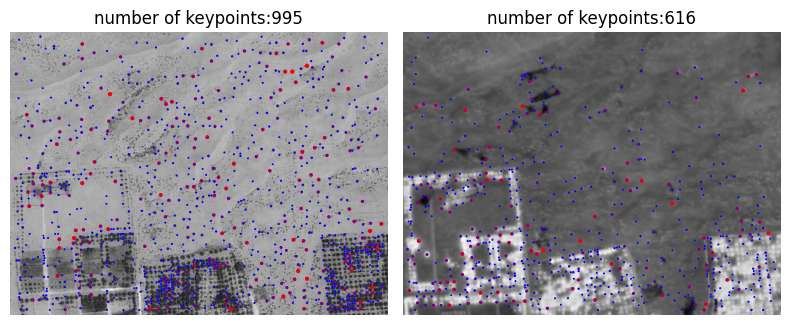

tensor(0.1044) tensor(0.0864)


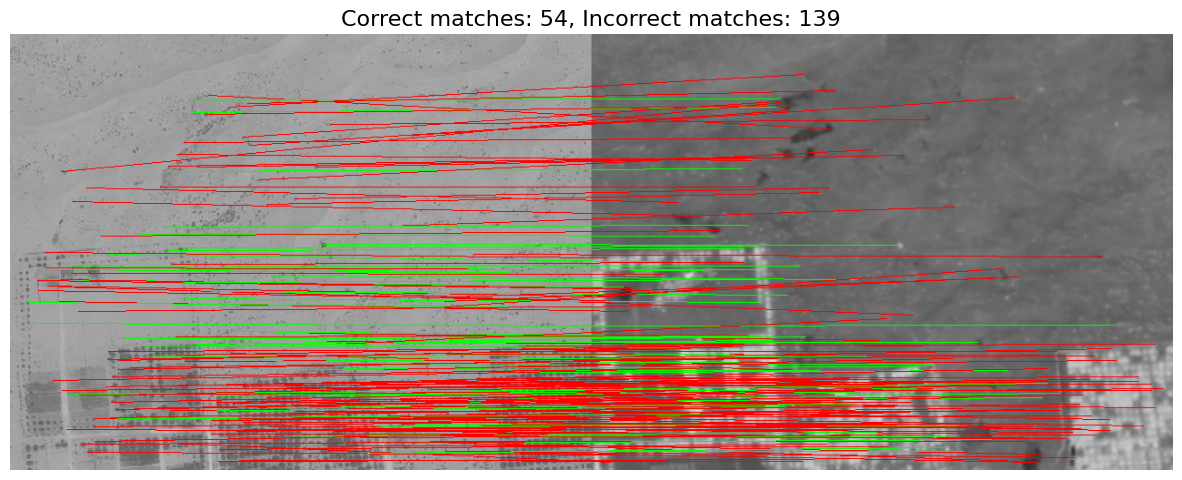

In [4]:
matches = gt_gen.process_image_pair(pair_id="tile_11", debug=False)

[DEBUG] Starting processing for image pair: None
[DEBUG] Using directly provided image pair.
[DEBUG] Loaded images: RGB (480, 640, 3), Thermal (480, 640, 3)
[DEBUG] Loaded images and grayscale images for pair None.
[DEBUG] Extracted keypoints for RGB and Thermal.


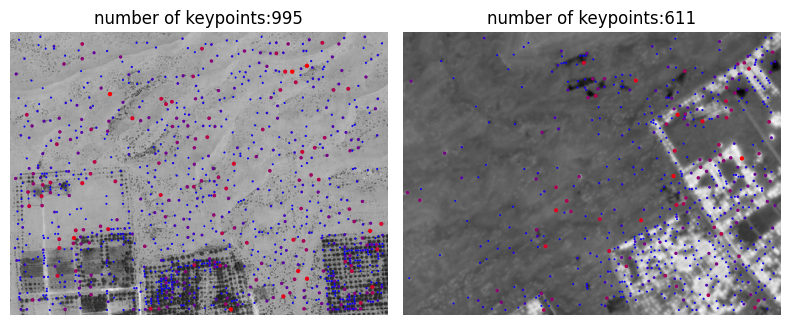

tensor(0.1044) tensor(0.0727)
[DEBUG] Computed 28 matches.


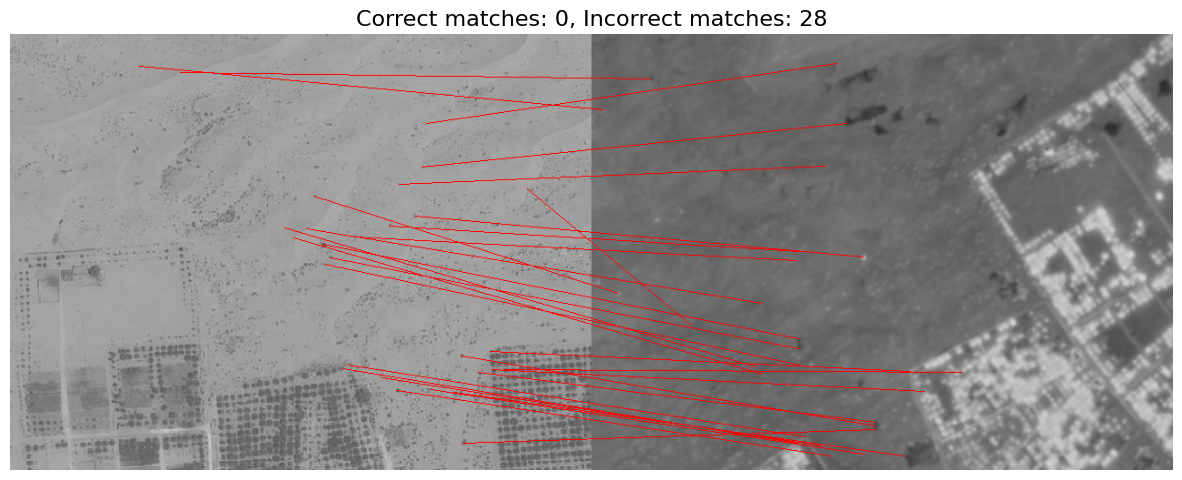

In [12]:
import cv2

rgb = cv2.imread(r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\rgb\satellite_tile_11.png")
thermal = cv2.imread(r"F:\IDM\SuperPoint\dataset\CGTD_Tool\aug_dataset\thermal\tile_11_aug3.png")

matches = gt_gen.process_image_pair(rgb_image=rgb, thermal_image=thermal, debug=True)


[DEBUG] Starting processing for image pair: None
[DEBUG] Using directly provided image pair.
[DEBUG] Loaded images: RGB (480, 640, 3), Thermal (480, 640, 3)
[DEBUG] Loaded images and grayscale images for pair None.
[DEBUG] Extracted keypoints for RGB and Thermal.


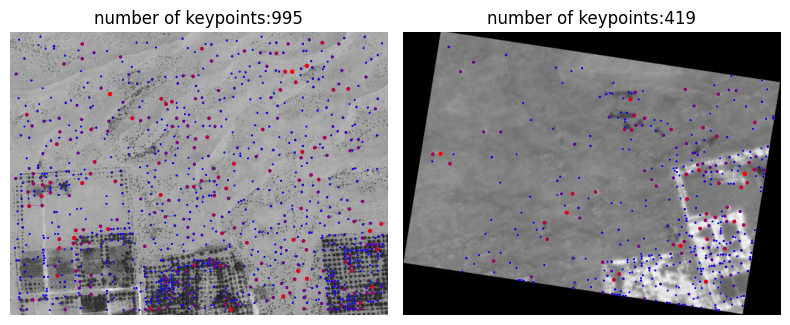

tensor(0.1044) tensor(0.0794)
[DEBUG] Computed 53 matches.


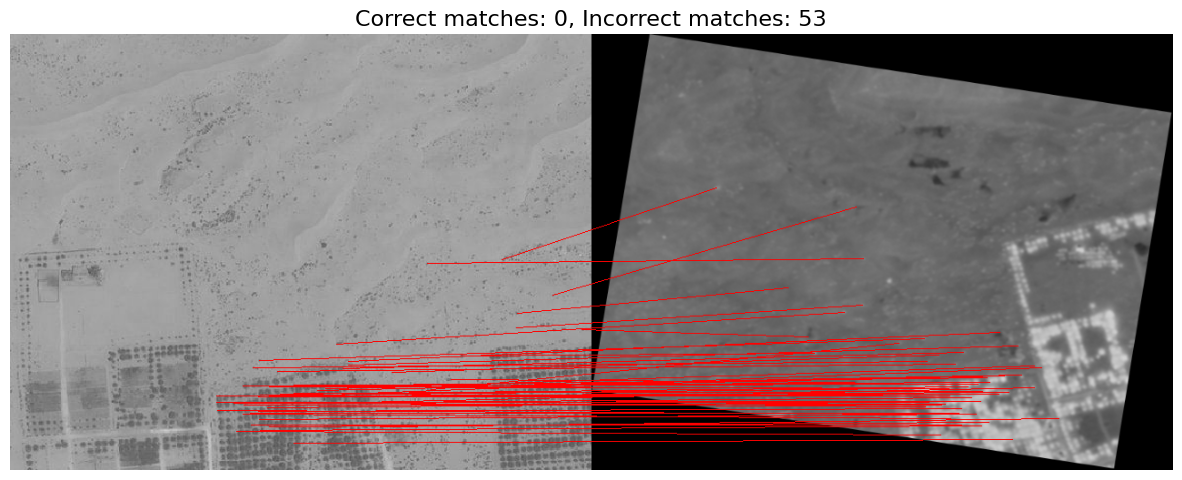

In [13]:
import cv2

rgb = cv2.imread(r"dataset\CGTD_Tool\dataset\rgb\satellite_tile_11.png")
thermal = cv2.imread(r"dataset\CGTD_Tool\aug_dataset\thermal\tile_11_aug2.png")

matches = gt_gen.process_image_pair(rgb_image=rgb, thermal_image=thermal, debug=True)


[DEBUG] Starting processing for image pair: None
[DEBUG] Using directly provided image pair.
[DEBUG] Loaded images: RGB (480, 640, 3), Thermal (480, 640, 3)
[DEBUG] Loaded images and grayscale images for pair None.
[DEBUG] Extracted keypoints for RGB and Thermal.


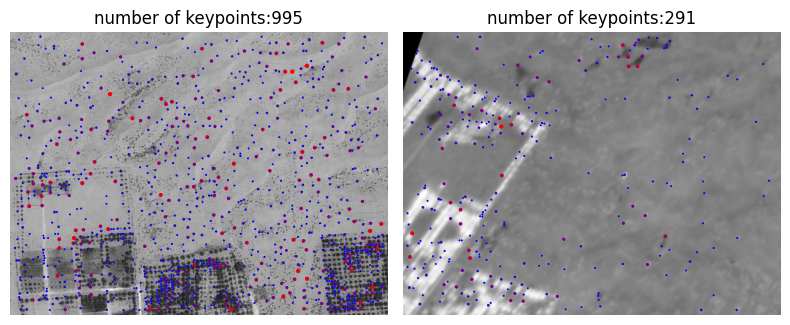

tensor(0.1044) tensor(0.0637)
[DEBUG] Computed 10 matches.


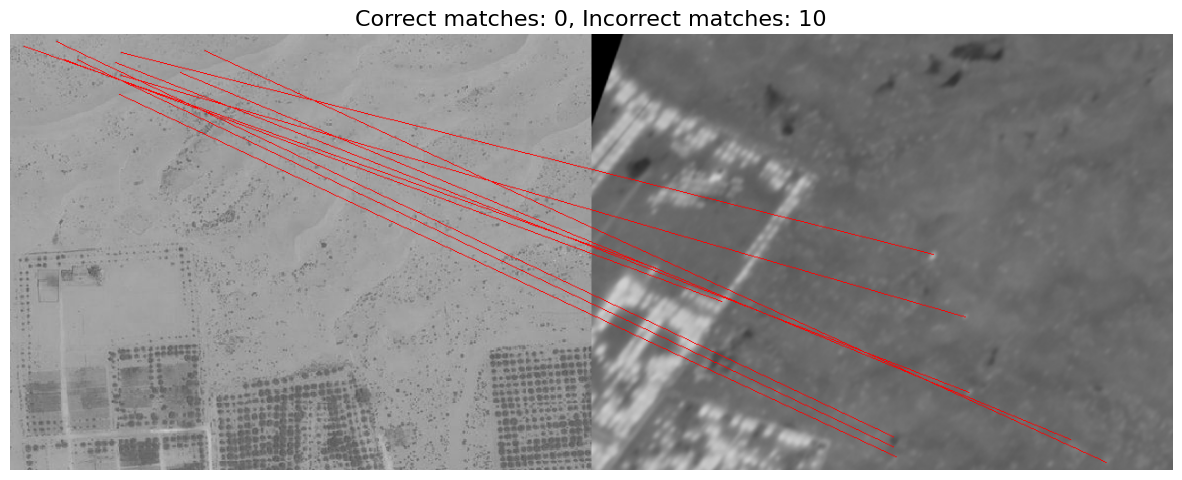

In [14]:
import cv2

rgb = cv2.imread(r"dataset\CGTD_Tool\dataset\rgb\satellite_tile_11.png")
thermal = cv2.imread(r"dataset\CGTD_Tool\aug_dataset\thermal\tile_11_aug1.png")

matches = gt_gen.process_image_pair(rgb_image=rgb, thermal_image=thermal, debug=True)


#### new testing keypoints: didn't work for me

In [ ]:
import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

yaml_path = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\kp_thermal\9.yaml"
fs = cv2.FileStorage(yaml_path, cv2.FileStorage_READ)
kp_thermal = fs.getNode("keypoints").mat()  # shape (N, 3) فرض می‌کنیم شامل x, y, response است
desc_thermal = fs.getNode("descriptors").mat().T  # Transpose -> (256, N)
fs.release()

if kp_thermal.shape[1] == 3:  
    score_thermal = kp_thermal[:, 2]  # ستون سوم به عنوان scores
else:  # اگر response وجود نداشته باشد، مقدار پیش‌فرض تنظیم می‌کنیم
    score_thermal = np.ones(kp_thermal.shape[0], dtype=np.float32)  # مقدار پیش‌فرض 1.0
kp_thermal = kp_thermal[:, :2]  # فقط x, y


In [ ]:

yaml_path = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\kp_rgb\9.yaml"

fs = cv2.FileStorage(yaml_path, cv2.FileStorage_READ)
kp_rgb = fs.getNode("keypoints").mat()  # shape (N, 3) فرض می‌کنیم شامل x, y, response است
desc_rgb = fs.getNode("descriptors").mat().T  # Transpose -> (256, N)
fs.release()

if kp_rgb.shape[1] == 3: 
    score_rgb = kp_rgb[:, 2]  # ستون سوم به عنوان scores
else: 
    score_rgb = np.ones(kp_rgb.shape[0], dtype=np.float32)  
kp_rgb = kp_rgb[:, :2]  # فقط x, y

In [ ]:
rgb_path = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\rgb\satellite_tile_9.png"
thermal_path = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\Data_CLAHE\thermal_tile_9.png"
rgb_image = cv2.imread(rgb_path)
thermal_image = cv2.imread(thermal_path)
rgb_image = cv2.resize(rgb_image, (640, 480))
thermal_image = cv2.resize(thermal_image, (640, 480))

# Convert images to RGB for display.
org_rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
org_thermal_image = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)
# Create grayscale versions for feature extraction.
grayscale_rgb_image = cv2.cvtColor(org_rgb_image, cv2.COLOR_BGR2GRAY)
grayscale_thermal_image = cv2.cvtColor(org_thermal_image, cv2.COLOR_BGR2GRAY)

grayscale_rgb_image = grayscale_rgb_image.astype(np.float32) / 255.0
grayscale_thermal_image = grayscale_thermal_image.astype(np.float32) / 255.0

grayscale_rgb_image = torch.from_numpy(grayscale_rgb_image).unsqueeze(0).unsqueeze(0).to(device)
grayscale_thermal_image = torch.from_numpy(grayscale_thermal_image).unsqueeze(0).unsqueeze(0).to(device)

In [ ]:
# تبدیل داده‌ها به تنسور
kp_thermal_t = torch.from_numpy(kp_thermal)[None].float().to(device)  # (1, N0, 2)
kp_sat_t = torch.from_numpy(kp_rgb)[None].float().to(device)  # (1, N1, 2)

desc_thermal_t = torch.from_numpy(desc_thermal).float().to(device)  # (1, 256, N0)
desc_sat_t = torch.from_numpy(desc_rgb).float().to(device)  # (1, 256, N1)

score_thermal_t = torch.from_numpy(score_thermal)[None].float().to(device)  # (1, N0)
score_sat_t = torch.from_numpy(score_rgb)[None].float().to(device)  # (1, N1)

In [ ]:
data = {
    'keypoints0': kp_sat_t,
    'keypoints1': kp_thermal_t,
    'descriptors0': desc_sat_t,
    'descriptors1': desc_thermal_t,
    'image0': grayscale_rgb_image,
    'image1': grayscale_thermal_image,
    'scores0': score_sat_t,
    'scores1': score_thermal_t,
}

In [ ]:
# چاپ کلیدها و نوع مقادیر آنها
for key, value in data.items():
    print(f"Key: {key}, Value Type: {type(value)}, Shape: {value.shape}")

Key: keypoints0, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1024, 2])
Key: keypoints1, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1024, 2])
Key: descriptors0, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([256, 1024])
Key: descriptors1, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([256, 1024])
Key: image0, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1, 480, 640])
Key: image1, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1, 480, 640])
Key: scores0, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1024])
Key: scores1, Value Type: <class 'torch.Tensor'>, Shape: torch.Size([1, 1024])


In [ ]:
print(score_thermal.mean(), score_rgb.mean())

0.099985026 0.12123718


In [ ]:
from GroundTruthGenerator import SuperGlueMatcher
matcher = SuperGlueMatcher(debug=True)

F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperGluePretrainedNetwork-master\models\superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(

Loaded SuperGlue model ("outdoor" weights)
[DEBUG] SuperGlueMatcher initialized.


In [ ]:
matches = matcher.match_keypoints(data)

[DEBUG] Found 0 valid matches out of 1024 keypoints.
[DEBUG] Converted matches to 0 coordinate pairs.


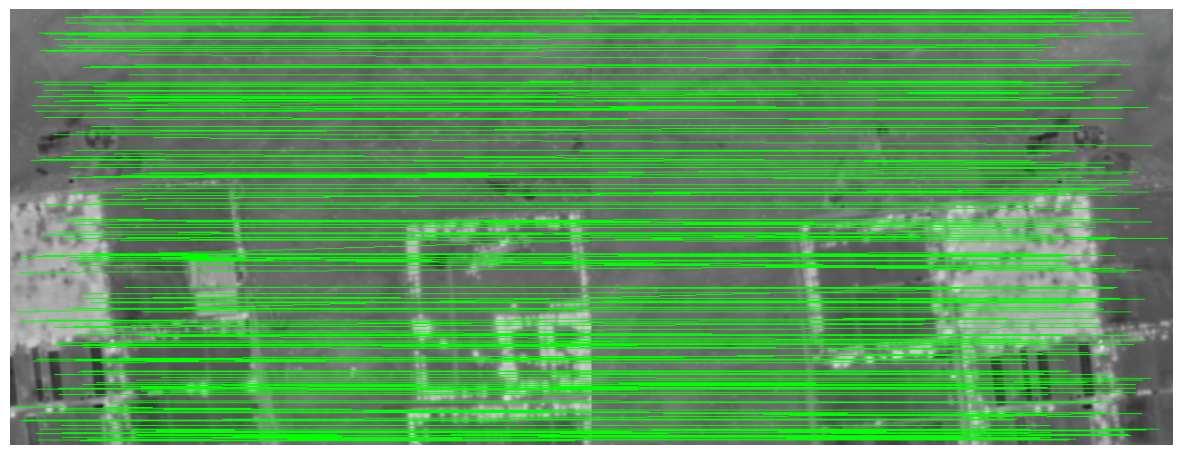

In [ ]:
import matplotlib.pyplot as plt
import cv2

img1 = cv2.imread(r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\thermal\thermal_tile_10.png")
img2 = cv2.imread(r"F:\IDM\SuperPoint\dataset\CGTD_Tool\dataset\thermal\thermal_tile_9.png")


out = cv2.hconcat([img1, img2])
w = img1.shape[1]

for pt0, pt1 in matches:
    pt1_shifted = (int(pt1[0]+w), int(pt1[1]))
    cv2.line(out, (int(pt0[0]), int(pt0[1])), pt1_shifted, (0,255,0), 1)

plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## SuperGlue - training

### Model

In [15]:
import torch
import torch.nn as nn
from models.superglue import SuperGlue  # مسیر فایل SuperGlue اصلی

class FineTunedSuperGlue(nn.Module):

    def __init__(self, pretrained_weights='outdoor', train_gnn_layers=0):
        """
        Args:
            train_gnn_layers (int): تعداد بلاک‌های آخر GNN که قابل یادگیری باشند
        """
        super().__init__()
        # 1. بارگذاری مدل pretrained
        self.base_model = SuperGlue({'weights': pretrained_weights})

        # 2.فریز کردن همه لایه‌ها 
        for param in self.base_model.parameters():
            param.requires_grad = False

        # 3. باز کردن لایه‌های قابل یادگیری (KeypointEncoder و Final Projection)
        for param in self.base_model.kenc.parameters():
            param.requires_grad = True

        for param in self.base_model.final_proj.parameters():
            param.requires_grad = True

        # 4. در صورت نیاز، باز کردن چند لایه‌ی آخر GNN
        if train_gnn_layers > 0:
            gnn_layers = list(self.base_model.gnn.layers)
            for layer in gnn_layers[-train_gnn_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

        # لاگ ها
        trainable = [n for n, p in self.named_parameters() if p.requires_grad]
        print(f"[FineTune Info] Trainable params: {len(trainable)} layers -> {trainable}")

    def forward(self, data):
        """
        ورودی های لازم از سوپرپوینت
        {
            'keypoints0': (B, N, 2),
            'keypoints1': (B, M, 2),
            'scores0': (B, N),
            'scores1': (B, M),
            'descriptors0': (B, D, N),
            'descriptors1': (B, D, M)
        }
        """
        return self.base_model(data)


In [ ]:

model = FineTunedSuperGlue(pretrained_weights='outdoor', train_gnn_layers=0)

# تعریف optimizer فقط روی پارامترهای باز
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-6
)


### Loss function

### preprocessing

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# فرض: FineTunedSuperGlue از قبل تعریف شده است (کدی که قبل‌تر ساختیم)

def train_superglue_finetune(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader = None,
    epochs: int = 10,
    lr: float = 1e-4,
    weight_decay: float = 1e-6,
    checkpoint_dir: str = "./checkpoints",
    resume_from: str = None,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    حلقه آموزش کامل با tqdm، checkpoint و اعتبارسنجی اختیاری
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    model = model.to(device)

    # Optimizer فقط روی پارامترهای باز
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=weight_decay
    )

    # Loss Function ساده برای matching (می‌تونی تغییرش بدی)
    criterion = nn.MSELoss()

    start_epoch = 0
    best_val_loss = float("inf")

    # اگر checkpoint قبلی موجود بود، ادامه بده
    if resume_from and os.path.exists(resume_from):
        ckpt = torch.load(resume_from, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        start_epoch = ckpt["epoch"] + 1
        best_val_loss = ckpt["best_val_loss"]
        print(f"✅ Resumed from {resume_from} (epoch {start_epoch})")

    # شروع training loop
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for batch in progress:
            # نمونه ورودی برای SuperGlue: batch = { 'image0', 'image1', 'keypoints0', ... }
            for k, v in batch.items():
                batch[k] = v.to(device)

            # Forward
            output = model(batch)

            # مثلاً فرض کنیم می‌خوایم predicted matches با ground-truth مقایسه بشن:
            if "matches_gt" in batch:
                loss = criterion(output["refined_matches"]["scores"], batch["matches_gt"])
            else:
                # اگر ground truth نداری، loss می‌تونه بر اساس consistency بین دو تصویر باشه
                loss = torch.mean(1.0 - output["refined_matches"]["scores"])  # placeholder

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress.set_postfix({"train_loss": f"{loss.item():.4f}"})

        avg_train_loss = running_loss / len(train_loader)

        # --- Validation ---
        val_loss = None
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    for k, v in batch.items():
                        batch[k] = v.to(device)
                    output = model(batch)
                    loss = torch.mean(1.0 - output["refined_matches"]["scores"])
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            print(f"Epoch {epoch+1} | Train: {avg_train_loss:.4f} | Val: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1} | Train: {avg_train_loss:.4f}")

        # --- Checkpoint ---
        ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": best_val_loss,
        }, ckpt_path)

        # اگر validation loss بهتر شد، بهترین مدل رو ذخیره کن
        if val_loader and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
            print(f"✅ Saved best model (val_loss={best_val_loss:.4f})")

    print("🎯 Training Finished!")


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

model = FineTunedSuperGlue(pretrained_weights='outdoor', train_gnn_layers=1)

train_superglue_finetune(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=1e-4,
    checkpoint_dir="./sg_checkpoints"
)
